In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# LSFF: Data gap filling with naive estimation


In [6]:
## load legal combos
import pickle
data_prep_dir = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_vehicle_country_pairs.pickle', 'rb') as handle:
    vehicle_country_map = pickle.load(handle)

In [7]:
summary_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/data_counts_full_3_11_2021.csv'
summary = pd.read_csv(summary_path)

## divide into value_descriptions to which the nutrient col is /isn't relevant

nutr_a = summary[summary.nutrient!='na']
nutr_na = summary[summary.nutrient=='na']

nutr_a = pd.pivot_table(nutr_a, index = ['location_name','vehicle','nutrient'], columns = 'value_description', values = 'mean_mean', dropna=False).reset_index()
nutr_na = pd.pivot_table(nutr_na, index = ['location_name','vehicle'], columns = 'value_description',values = 'mean_mean', dropna=False).reset_index()
df = nutr_a.merge(nutr_na, on = ['location_name','vehicle'], how = 'outer')

In [8]:
## filter back down to applicable variables

country_veh_filter = [v in country_vehicle_map[c] for (v,c) in zip(df.vehicle,df.location_name)]
vehicle_nutr_filter = [n in vehicle_nutrient_map[v] for (n,v) in zip(df.nutrient,df.vehicle)]

df = df[[x and y for (x,y) in zip(country_veh_filter,vehicle_nutr_filter)]]

In [9]:
value_d_codes = {'percent of population eating vehicle': 'A',
                 'percent of population eating industrially produced vehicle': 'B',
                 'percent of population eating fortified vehicle': 'C',
                 'percent of vehicle that is industrially produced': 'D',
                 'percent of vehicle that is fortified': 'E',
                 'percent of market covered by fortified product': 'F'}
df = df.rename(columns=value_d_codes)[['location_name','vehicle','nutrient','A','B','C','D','E','F']]

In [10]:
df.head()

value_description,location_name,vehicle,nutrient,A,B,C,D,E,F
7,Angola,maize flour,folic acid,NaN,NaN,NaN,0.0,0.0,NaN
8,Angola,maize flour,iron,NaN,NaN,NaN,0.0,0.0,NaN
9,Angola,maize flour,vitamin a,NaN,NaN,NaN,0.0,NaN,NaN
10,Angola,maize flour,vitamin b1,NaN,NaN,NaN,0.0,0.0,NaN
11,Angola,maize flour,vitamin b12,NaN,NaN,NaN,0.0,0.0,NaN


In [11]:
df.location_name = df.location_name.astype(str)
df.vehicle = df.vehicle.astype(str)
df.nutrient = df.nutrient.astype(str)

df.dtypes

value_description
location_name     object
vehicle           object
nutrient          object
A                float64
B                float64
C                float64
D                float64
E                float64
F                float64
dtype: object

In [12]:
df[(df.location_name=="Democratic Republic of the Congo")]

value_description,location_name,vehicle,nutrient,A,B,C,D,E,F
252,Democratic Republic of the Congo,bouillon,folic acid,NaN,NaN,NaN,NaN,NaN,NaN
253,Democratic Republic of the Congo,bouillon,iron,NaN,NaN,NaN,NaN,NaN,NaN
254,Democratic Republic of the Congo,bouillon,vitamin a,NaN,NaN,NaN,NaN,NaN,NaN
258,Democratic Republic of the Congo,bouillon,zinc,NaN,NaN,NaN,NaN,NaN,NaN
259,Democratic Republic of the Congo,maize flour,folic acid,45.255,NaN,NaN,5.0,NaN,NaN
260,Democratic Republic of the Congo,maize flour,iron,45.255,NaN,NaN,5.0,NaN,NaN
261,Democratic Republic of the Congo,maize flour,vitamin a,45.255,NaN,NaN,5.0,NaN,NaN
262,Democratic Republic of the Congo,maize flour,vitamin b1,45.255,NaN,NaN,5.0,NaN,NaN
263,Democratic Republic of the Congo,maize flour,vitamin b12,45.255,NaN,NaN,5.0,NaN,NaN
265,Democratic Republic of the Congo,maize flour,zinc,45.255,NaN,NaN,5.0,NaN,NaN


In [13]:
# A : "percent of population eating vehicle"
# B : "percent of population eating industrially produced vehicle"
# C : "percent of population eating fortified vehicle"

# D : "percent of vehicle that is industrially produced"
# E : "percent of vehicle that is fortified"

# C_0 : guess of "percent of population eating fortified vehicle" based on a
#       lack of evidence in the GFDx and data on other nutrient for the same loc-veh pair
# E_0 : guess of percent of vehicle that is fortified, based on a lack of evidence in the GFDx
#       and data on other nutrient for the same loc-veh pair

# B_1: percent of pop eating vehicle * percent of vehicle that is industrially prod = A * D

# C_1 : percent of population eating vehicle * percent of vehicle that is fortified = A * E
# C_1_0: percent of population eating vehicle * guess of percent of vehicle that is fortified = A * E_0

# C_2 : percent of population eating industrially produced vehicle * percent of vehicle that is fortified = B * E
# C_2_0: percent of population eating ind prod vehicle * guess of percent of vehicle that is fortified = B * E_0

# C_3 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * percent of vehicle that is fortified = A * D * E
# C_3_0 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * guess of percent of vehicle that is fortified = A * D * E_0

In [14]:
# run diagnostics on these and then choose or average some. always perfer A/B/C to estimates.

In [15]:
def pull_fort_legislation():
    fort_legislation_path = '/snfs1/Project/simulation_science/lsff/01_LSFF_GBD_2019/fortification_legislation_data.csv'
    df = pd.read_csv(fort_legislation_path, encoding = 'iso-8859-1')

    nutrient_rename = {i:i.lower() for i in df.Micronutrient.unique()}
    vehicle_rename = {i:i.lower() for i in df.Vehicle.unique()}
    loc_rename = {'Cote d\x92Ivoire':"Côte d'Ivoire", 'Tanzania':"United Republic of Tanzania", 'Viet Nam':"Vietnam"}

    df['nutrient'] = df.Micronutrient.map(nutrient_rename)
    df['vehicle'] = df.Vehicle.map(vehicle_rename)
    df['location_name'] = df.Country
    df.loc[df.location_name.isin(loc_rename.keys()),'location_name'] = df.location_name.map(loc_rename)
    df.rename(columns={'Standard':'standard'}, inplace=True)

    return df[['location_name','vehicle','nutrient','standard']]

fort_legislation = pull_fort_legislation()

In [16]:
df = fort_legislation.merge(df, on = ['location_name','vehicle','nutrient'], how = 'right')

In [17]:
## make sure all tuples are still valid

country_veh_filter = [v in country_vehicle_map[c] for (v,c) in zip(df.vehicle,df.location_name)]
vehicle_nutr_filter = [n in vehicle_nutrient_map[v] for (n,v) in zip(df.nutrient,df.vehicle)]

assert(len(df[[not (x and y) for (x,y) in zip(country_veh_filter,vehicle_nutr_filter)]])==0)

In [18]:
df.standard.unique()

array(['Unknown', 'Voluntary', 'Mandatory', 'None',
       'Mandatory in Punjab only', nan], dtype=object)

In [19]:
# if not mandatory, we'll guess pct fortified = 0
df.loc[(df.standard!='Mandatory'),'C_0'] = 0
df.loc[(df.standard!='Mandatory'),'E_0'] = 0

In [20]:
#for each location
    #for each vehicle
        #for a nutrient_i:
            #if the GFDx has evidence of mandatory loc-veh-nutrient_i fortification
                #if we don't have data for loc-veh-nutrient_i
                    #if we do have data for loc-veh-{nutrient_j,k,...,n}:
                        # assign mean(loc-veh-{nutrient_j,k,...,n}) to nutrient_i

In [21]:
count_c, count_e = 0, 0
for loc in df.location_name.unique():
    for v in country_vehicle_map[loc]:
        for n in vehicle_nutrient_map[v]:
#             if there is evidence of Mandatory fortification for this tuple
            if df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                      (df.standard=="Mandatory")].shape[0]>0:
                mean_C = df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                        (df.standard=="Mandatory"),'C'].mean()
                mean_E = df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                        (df.standard=="Mandatory"),'E'].mean()
                if not np.isnan(mean_C):
                    count_c += 1
                    df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                      (df.standard=="Mandatory"),'C_0'] = mean_C
                if not np.isnan(mean_E):
                    count_e += 1
                    df.loc[(df.location_name==loc) &
                      (df.vehicle==v) &
                      (df.nutrient==n) &
                      (df.standard=="Mandatory"),'E_0'] = mean_E

In [22]:
count_c, count_e

(55, 103)

In [23]:
# A : "percent of population eating vehicle"
# B : "percent of population eating industrially produced vehicle"
# C : "percent of population eating fortified vehicle"

# D : "percent of vehicle that is industrially produced"
# E : "percent of vehicle that is fortified"

# C_0 : guess of "percent of population eating fortified vehicle" based on a
#       lack of evidence in the GFDx and data on other nutrient for the same loc-veh pair
# E_0 : guess of percent of vehicle that is fortified, based on a lack of evidence in the GFDx
#       and data on other nutrient for the same loc-veh pair

# B_1: percent of pop eating vehicle * percent of vehicle that is industrially prod = A * D

# C_1 : percent of population eating vehicle * percent of vehicle that is fortified = A * E
# C_1_0: percent of population eating vehicle * guess of percent of vehicle that is fortified = A * E_0

# C_2 : percent of population eating industrially produced vehicle * percent of vehicle that is fortified = B * E
# C_2_0: percent of population eating ind prod vehicle * guess of percent of vehicle that is fortified = B * E_0

# C_3 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * percent of vehicle that is fortified = A * D * E
# C_3_0 : percent of population eating vehicle * percent of vehicle that is industrially prod
#                                           * guess of percent of vehicle that is fortified = A * D * E_0

In [24]:
df.loc[(df.A.notna()) & (df.D.notna()),'B_1'] = df.A * df.D *.01

df.loc[(df.A.notna()) & (df.E.notna()),'C_1'] = df.A * df.E *.01
df.loc[(df.A.notna()) & (df.E_0.notna()),'C_1_0'] = df.A * df.E_0 *.01

df.loc[(df.B.notna()) & (df.E.notna()),'C_2'] = df.B * df.E *.01
df.loc[(df.B.notna()) & (df.E_0.notna()),'C_2_0'] = df.B * df.E_0 *.01

df.loc[(df.A.notna()) & (df.D.notna()) & (df.E_0.notna()),'C_3'] = df.A * df.D * df.E_0 * .0001
df.loc[(df.A.notna()) & (df.D.notna()) & (df.E_0.notna()),'C_3_0'] = df.A * df.D * df.E_0 * .0001

In [25]:
def abs_error(df, x):
    ref = x[6:7]
    est = x[6:]
    df.loc[(df[ref].notna()) & (df[est].notna()),x] = np.abs(df[ref] - df[est])
    return df


errors = [f'error_{i}' for i in ['B_1','C_1','C_1_0','C_2','C_2_0','C_3','C_3_0']]

for x in errors:
    df = abs_error(df, x)

In [26]:
df[errors].describe()

,error_B_1,error_C_1,error_C_1_0,error_C_2,error_C_2_0,error_C_3,error_C_3_0
count,117.000000,60.000000,67.000000,55.000000,63.000000,60.000000,60.000000
mean,19.209296,14.107645,12.916921,12.843479,10.773751,7.872745,7.872745
std,19.299542,17.580713,17.328871,15.482220,15.414976,10.284676,10.284676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.571667,1.657933,1.519333,1.519333,1.400000,1.519333,1.519333
50%,15.003333,5.123000,3.414400,5.053000,3.200000,3.200000,3.200000
75%,25.020000,32.521550,31.921400,31.764925,12.506744,7.051300,7.051300
max,81.315500,71.378111,71.378111,50.000000,80.000000,35.000000,35.000000


/ihme/code/central_comp/miniconda_svc-ccomp/envs/v106/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/ihme/code/central_comp/miniconda_svc-ccomp/envs/v106/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


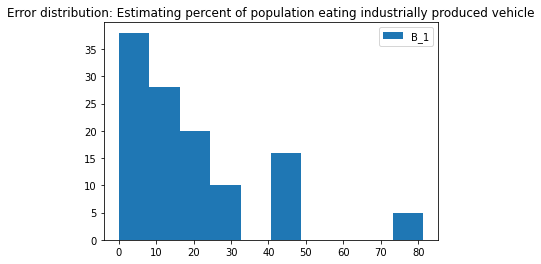

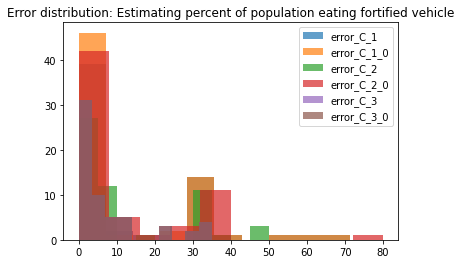

In [27]:
plt.title('Error distribution: Estimating percent of population eating industrially produced vehicle')
plt.hist(df.error_B_1, label = "B_1")
plt.legend()
plt.show()

plt.title('Error distribution: Estimating percent of population eating fortified vehicle')
for x in errors[1:]:
    plt.hist(df[x], alpha = 0.7, label = x)
    
plt.legend()
plt.show()

In [28]:
def checkout_metrics(df, x):
    out = pd.DataFrame({
        'col':[x],
        'error_rate':[df[x].sum() / len(df[x].notna())],
        'sample_size':[sum(df[x].notna())],
        'total_relative_error':[df[errors].dropna().sum()[x]],
        'total_absolute_error':[df[x].sum()]
    })
    return out

In [29]:
metrics = pd.concat([checkout_metrics(df, x) for x in errors[1:]])
metrics

,col,error_rate,sample_size,total_relative_error,total_absolute_error
0,error_C_1,2.411563,60,691.472518,846.458695
0,error_C_1_0,2.465623,67,681.397511,865.433688
0,error_C_2,2.012511,55,668.759870,706.391337
0,error_C_2_0,1.933750,63,531.814839,678.746306
0,error_C_3,1.345768,60,443.064705,472.364705
0,error_C_3_0,1.345768,60,443.064705,472.364705


In [30]:
c_estimates = ['C_1','C_1_0','C_2','C_2_0','C_3','C_3_0']
df['C_n'] = df[c_estimates].mean(axis=1)

In [31]:
df['A_final'] = df.A

In [32]:
df['B_final'] = [b if pd.notna(b) else b1 for (b,b1) in zip(df.B,df.B_1)]
df['B_estimate'] = [0 if pd.notna(b) else 1 if pd.notna(b1) else np.nan for (b,b1) in zip(df.B,df.B_1)]

In [33]:
df['C_final'] = [c if pd.notna(c) else cn for (c,cn) in zip(df.C,df.C_n)]
df['C_estimate'] = [0 if pd.notna(c) else 1 if pd.notna(cn) else np.nan for (c,cn) in zip(df.C,df.C_n)]

In [34]:
output = df[['location_name', 'vehicle', 'nutrient', 'standard','A_final','B_final','B_estimate','C_final','C_estimate']]
output.rename(columns = {'A_final':'A',
                        'B_final':'B',
                        'C_final':'C'}, inplace = True)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v106/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [35]:
value_d_codes

{'percent of population eating vehicle': 'A',
 'percent of population eating industrially produced vehicle': 'B',
 'percent of population eating fortified vehicle': 'C',
 'percent of vehicle that is industrially produced': 'D',
 'percent of vehicle that is fortified': 'E',
 'percent of market covered by fortified product': 'F'}

In [34]:
# inverse_value_d_codes = {v:k for (k,v) in zip(value_d_codes.keys(),value_d_codes.values())}

# output.rename(columns = inverse_value_d_codes, inplace = True)

In [35]:
## make sure all tuples are still valid

country_veh_filter = [v in country_vehicle_map[c] for (v,c) in zip(output.vehicle,output.location_name)]
vehicle_nutr_filter = [n in vehicle_nutrient_map[v] for (n,v) in zip(output.nutrient,output.vehicle)]

assert(len(output[[not (x and y) for (x,y) in zip(country_veh_filter,vehicle_nutr_filter)]])==0)

In [36]:
save_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_data_estimated_03_11_2021.csv'

In [37]:
output.to_csv(save_path, index = False)